<a href="https://colab.research.google.com/github/prithsha/erav2/blob/main/ERA_Session_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CODE BLOCK: 1

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [34]:
# CUDA?
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("CUDA Available?", use_cuda)

CUDA Available? True


CODE BLOCK: 3

In [35]:
# Train data transformations
# transforms.Compose function serves as a powerful tool for chaining multiple image transformations together in a specific order.
#  useful in the context of preparing image data for deep learning tasks like image classification, object detection, and more.
# We are doing data augmentation. It helps for making your machine learning models more robust, generalizable, and data-efficient,
# ultimately leading to better performance on real-world tasks.
train_transforms = transforms.Compose([
    # extracts a square crop of size 22x22 from the center of the original image.
    # making the training process more robust to minor variations in image content.
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    # Resizes the image to a fixed size of 28x28, regardless of its original dimensions.
    transforms.Resize((28, 28)),
    # Applies a random rotation between -15 and 15 degrees to the image.
    # The fill=0 argument specifies that empty pixels created by rotation should be filled with black (value 0).
    transforms.RandomRotation((-15., 15.), fill=0),
    # PyTorch models operate on tensors, so this conversion is necessary for feeding data into the model.
    transforms.ToTensor(),
    # The given values suggest the dataset has a mean of 0.1307 and a standard deviation of 0.3081 for each channel
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
# We are not using same mean and SD as we have augmented the data in training data set.
# Data augmentation artificially expands the training dataset by introducing random variations like crops, rotations, flips, etc.
# If you use data augmentation: calculate separate mean and standard deviation for each dataset independently to avoid introducing biases into the evaluation.
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1407,), (0.4081,))
    ])

CODE BLOCK: 4

In [36]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, transform=test_transforms)

CODE BLOCK: 5

In [37]:
batch_size = 512

# batch_size: This specifies the number of samples to group together into a batch when feeding data to your model. 
# shuffle (bool, default=False): When set to True, the data is shuffled at the beginning of each epoch, helping the model learn from different combinations of samples and avoid overfitting.
# num_workers (int, default=0): Controls the number of worker processes used for loading data in parallel. Higher values can improve speed but come with added overhead.
# pin_memory (bool, default=False): When set to True, tensors are copied to pinned memory before returning them. This speeds up GPU transfers as pinned memory is specifically optimized for GPU access.

kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

CODE BLOCK: 6

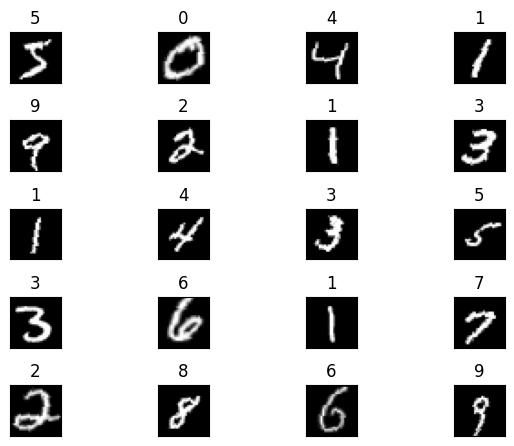

In [38]:
import matplotlib.pyplot as plt

# retrieve a batch of data and labels from a training dataset loader
# batch_label holds the labels associated with each sample in that batch.
# These labels indicate the correct category or value you want your model to learn to predict for each data point.
batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(20):
  plt.subplot(5,4,i+1)
  plt.tight_layout()
  # The squeeze() method removes any dimensions with size 1 from the tensor.
  # The 0 argument specifies that only the dimension at index 0 should be squeezed if it has size 1.
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [39]:
class Net(nn.Module):
    #This defines the structure of the NN.
    # Four convolutional layers (Conv2d):
    # Two fully-connected layers (Linear):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(256, 50)
        self.fc2 = nn.Linear(50, 10)

    # The convolutional layers extract features from the image,
    # while the fully-connected layers learn higher-level representations and make predictions.
    def forward(self, x):
        x = F.relu(self.conv1(x), 2)
        # Applies ReLU activation function and 2x2 max pooling after convolutional layer.
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x), 2)
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        # Flattens the output of the last convolutional layer into a 1D vector using view.
        print(x.shape)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

CODE BLOCK: 8

In [40]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [43]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    print(data.size(), target.size())
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [45]:
model = Net().to(device)

from torchsummary import summary
summary(model, input_size=(1, 28, 28))

optimizer = optim.SGD(model.parameters(), lr=10.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 2

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, train_loader, criterion)
  scheduler.step()

torch.Size([2, 256, 4, 4])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]          12,850
            Linear-6                   [-1, 10]             510
Total params: 401,200
Trainable params: 401,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 1.53
Estimated Total Size (MB): 2.20
----------------------------------------------------------------
Epoch 1


  0%|          | 0/118 [00:55<?, ?it/s]


KeyboardInterrupt: 

CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

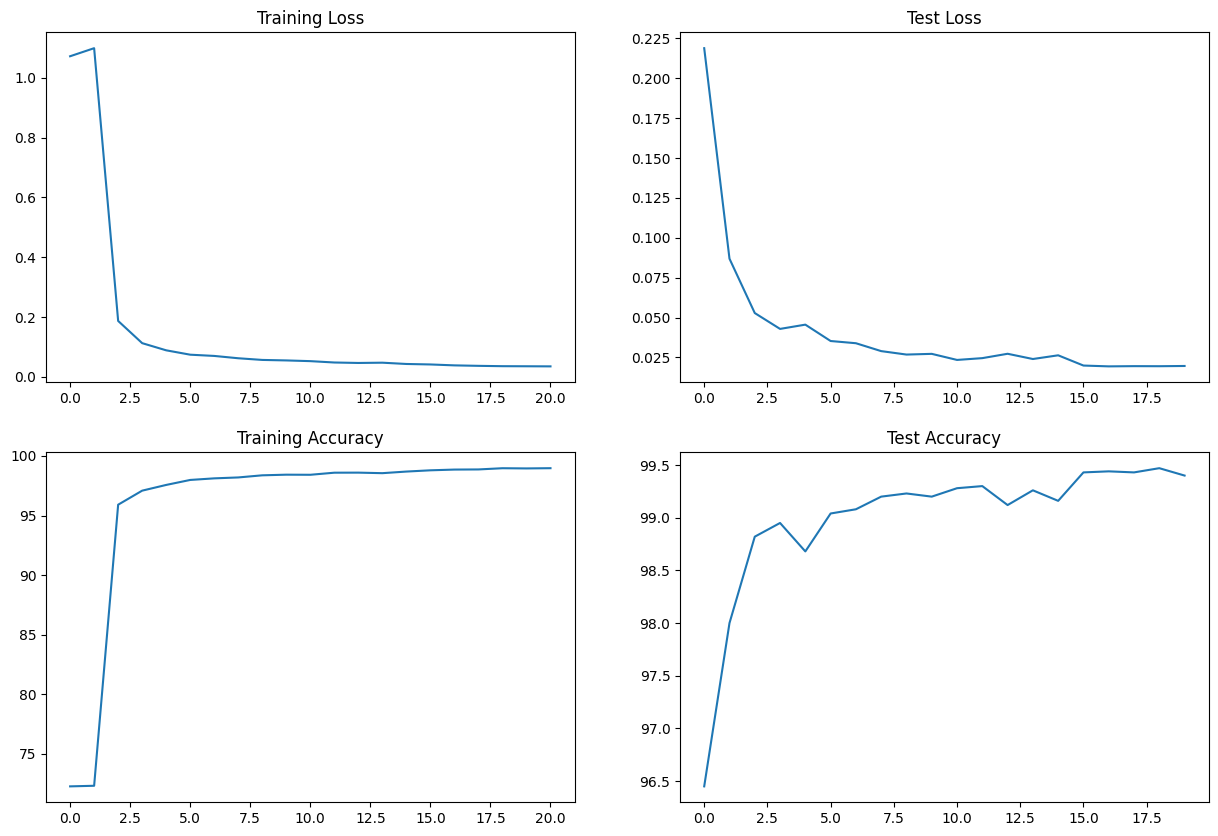

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

torch.Size([2, 256, 4, 4])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]          12,850
            Linear-6                   [-1, 10]             510
Total params: 401,200
Trainable params: 401,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 1.53
Estimated Total Size (MB): 2.20
----------------------------------------------------------------
